# Dacon-emnist_competition

## # Import libraries

In [2]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
from sklearn.model_selection import train_test_split

In [3]:
warnings.filterwarnings("ignore")
%matplotlib inline

#Random seed
np.random.seed(7)
random.seed(7)

# pytorch
torch.cuda.is_available()

True

In [4]:
train = pd.read_csv('./input/train.csv')
test  = pd.read_csv('./input/test.csv')
submission = pd.read_csv('./input/submission.csv')

## # Exploratory data analysis

In [94]:
train.head()

,digit,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,1,1,1,4,3,0,0,4,4,...,2,1,0,1,2,4,4,4,3,4
1,0,0,4,0,0,4,1,1,1,4,...,0,3,0,1,4,1,4,2,1,2
2,4,1,1,2,2,1,1,1,0,2,...,3,3,3,0,2,0,3,0,2,2
3,9,1,2,0,2,0,4,0,3,4,...,3,3,2,0,1,4,0,0,1,1
4,6,3,0,2,4,0,3,0,4,2,...,4,4,3,2,1,3,4,3,1,2


In [78]:
test.head()

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


* 주어진 data는 28x28 (784개 픽셀) 이미지이다.
* 전체 데이터 22528개 중 2048개는 학습데이터, 20480개는 테스트데이터로 주어졌다.
* 학습 데이터가 적기 때문에 semi-supervised learning과 data augmentation이 중요해 보인다.
* target value는 digit이다. (나중에 Dataframe 만들때 추가할 것)

In [79]:
img = train.query("letter == 'A'")
img.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2
17,18,7,A,2,3,0,4,0,0,1,...,1,2,0,0,1,0,2,2,1,4
44,45,5,A,2,0,4,2,3,1,3,...,3,1,2,0,4,2,3,4,1,1
75,76,7,A,1,0,4,1,4,1,1,...,0,4,0,4,3,2,4,1,2,2
105,106,2,A,4,2,4,1,0,4,3,...,0,2,0,2,4,3,2,3,0,1


In [80]:
img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
#img

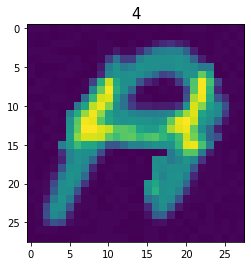

In [81]:
# img show
# A로 이루어진 dataframe의 28번째 행은 digit가 4이다.
# 각 value는 0~255인 듯하다.

img = train.query("letter == 'A'")[[(str(i)) for i in range(784)]].iloc[28].values.reshape(28, 28)
plt.imshow(img)
plt.title(train.query("letter == 'A'").iloc[28]['digit'], fontsize=15)
plt.show()

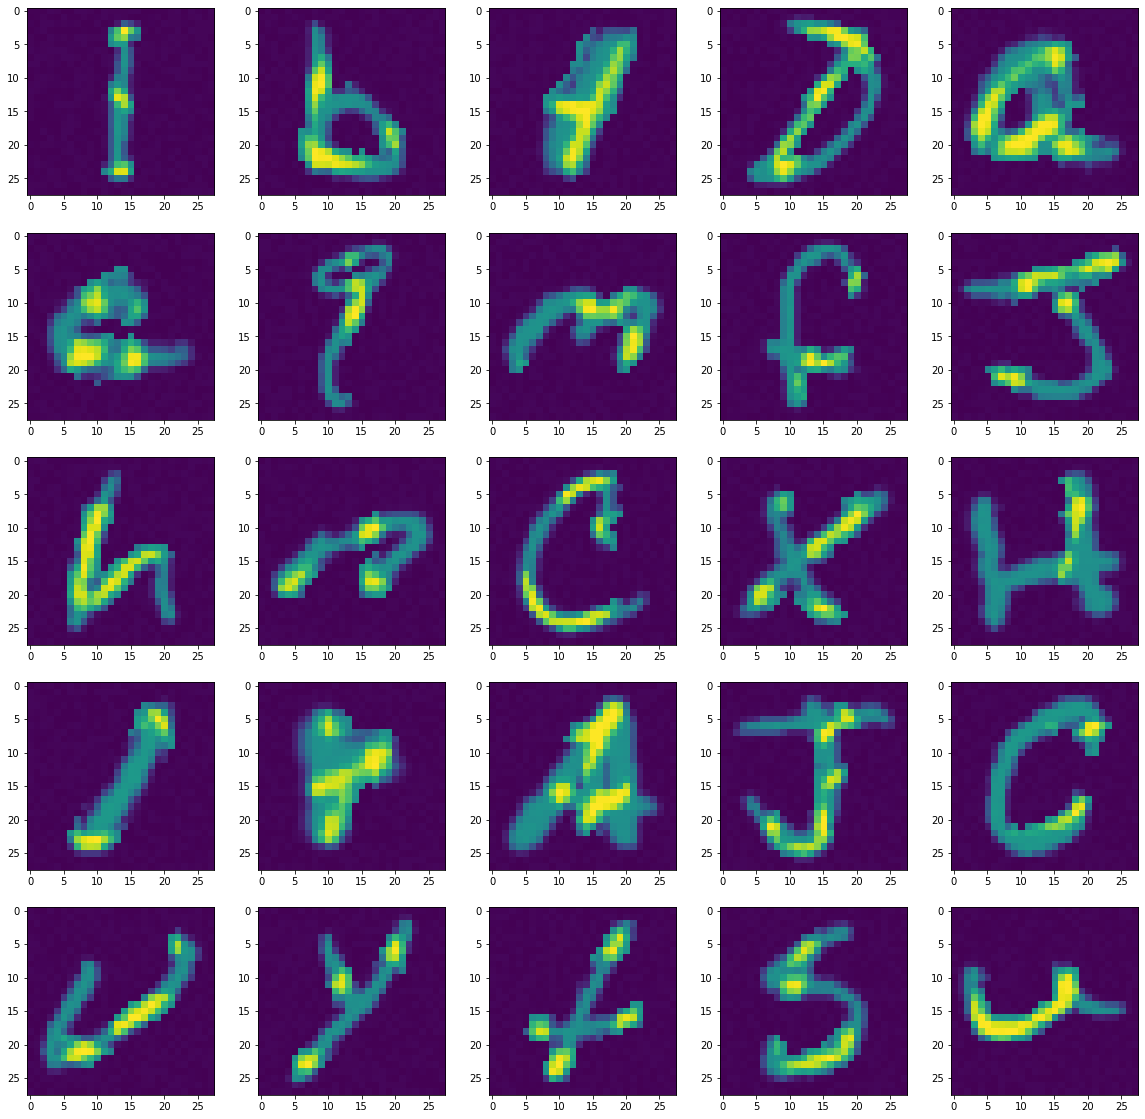

In [83]:
# multi-img show

#img2 = train.iloc[0,3:].values.reshape(28, 28)
#img2

imgs = []

plt.figure(figsize=(20,20))

for i in range(25):
    img = train.iloc[i,3:].values.reshape(28, 28)
    imgs.append(img)

# list 자료형으로는 img를 나타낼 수 없으므로 numpy 자료형으로 바꾸어 준다.    
# 데이터 타입 에러 발생으로 np.float32를 추가해준다
imgs = np.array(imgs)
imgs = imgs.astype(np.float32)

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(imgs[i, :, :])

plt.subplot(5,5,25)
plt.imshow(imgs[-1, :,:])
plt.show()


1. 데이터에 대문자와 소문자가 섞여 있다.
2. 데이터에 알아보기 힘든 글자도 존재한다.
3. target value(digit)은 영어 글자와 숫자가 겹치는 부분만 특징적으로 노란색으로 나타나게 조작되었다.
4. 내 생각에는 커널을 붙여서 숫자 데이터만 만든 후 그걸 학습시키는게 나을듯  (맞춰야 하는 건 숫잔데 글자도 학습될 여지 있음)
5. 진짜 제대로 정확하게 하려면 지워진 숫자 글씨의 부분들을 restoration해서 학습시키는게 좋을듯
   (주어진 같은 글자를 겹쳐서 하나의 숫자로 만들어 비교하면 되지 않을까)

## # VGG16 modeling

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.lst_label)
    
    def __getitem__(self,index):
        data = pd.read_csv(self.data_dir)

        del data['id']
        del data['letter']

        label = data['digit']
        input = []

        for i in range(2048):
            temp = data.iloc[i,1:].values.reshape(28, 28)
            input.append(temp)

        # list 자료형으로는 img를 나타낼 수 없으므로 numpy 자료형으로 바꾸어 준다.    
        # 데이터 타입 에러 발생으로 np.float32를 추가해준다. (하기 정규화시 필요)
        label = (np.array(label)).astype(np.float32)
        input = (np.array(input)).astype(np.float32)
    
        input = input/255.0

        # pytorch에 들어가는 dimension은 input이 3개의 축을 가져야 한다.
        if input.ndim ==3:
            input = input[:, :, :, np.newaxis]
            
        # 참고> input.shape : (2048, 28, 28 ,1) / label.shape : (2048, )
                  
        data = {'input' : input, 'label' : label}
        
        if self.transform:
            data = self.transform(data)
            
        return data

In [ ]:
## 트렌스 폼 구현하기

# nnConv2D 는 nSamples x nChannels x Height x Width 의 4차원 Tensor를 입력을 기본으로 하고
# 샘플 수에 대한 차원이 없을땐 채널, 세로, 가로만 입력해도 되는듯 하다.

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        # (2048, 28, 28, 1) → (2048, 1, 28, 28)
        # (샘플수, 가로, 세로, 채널) → (2048, 채널, 가로, 세로)
        # 값을 확인해봐도 자리가 바뀌는 게 아니라 순서가 바뀌어 있다.
        input = np.moveaxis(input[:,:,:,:],-1,1)
        
        data = {'label' : torch.from_numpy(label), 'input' : torch.from_numpy(input)}
        
        return data
    
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std
        
    def __call__(self,data):
        label, input = data['label'], data['input']
        
        input = (input - self.mean) / self.std
        
        return data
    
class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        if np.random.rand() > 0.5
            label = np.fliplr(label)
            input = np.fliplr(input)
            
        if np.random.rand() > 0.5
            label = np.fliqud(label)
            input = np.fliqud(input)
            
        data = {'label' : label, 'input' : input}
        
        return data

In [ ]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # Contracting path
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # Expansive path
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [54]:
# 문자는 one-hot encoding한 후에 (-1, 1, 26)으로 reshape
# pixel값들도 (-1, 1, 784)로 reshape
# 그 후 concat하여 (2048, 1, 810)으로 X_train 구축
X_train = np.concatenate(
    [
        pd.get_dummies(train.letter).values.reshape(-1, 1, 26),
        (train[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)
# Label Setting
y_train = train['digit'].values

# Train-Test를 8:2로 분할
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [55]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1638, 1, 810), (410, 1, 810), (1638,), (410,))

In [56]:
# Torch.Tensor로 형변환
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.LongTensor(y_train)
y_valid = torch.LongTensor(y_valid)

In [57]:
from torch.utils.data import (
    TensorDataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)


# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(
    X_train[:, :, :26], # Letter
    X_train[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_train # Label
)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(
    train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(
    X_valid[:, :, :26], # Letter
    X_valid[:, :, 26:].reshape(-1, 1, 28, 28), # Image (28, 28)
    y_valid # Label
)
validation_sampler = SequentialSampler(
    validation_data)
validation_dataloader = DataLoader(
    validation_data, sampler=validation_sampler, batch_size=batch_size)

In [58]:
# Model Construct

class ConvClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # Letter를 처리할 1D Conv Block
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 64, 4, padding=1), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 64, 4, padding=2), nn.ReLU(),
            nn.Conv1d(64, 16, 3), nn.ReLU(),
        )
        
        # Image를 처리할 2D Conv Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 128, 5, padding=2), nn.ReLU(),
            nn.Conv2d(128, 256, 7, padding=3), nn.ReLU(),
            nn.Conv2d(256, 512, 9, padding=3), nn.ReLU(),
            nn.Conv2d(512, 256, 9, padding=3), nn.ReLU(),
            nn.Conv2d(256, 128, 7, padding=3), nn.ReLU(),
            nn.Conv2d(128, 64, 7, padding=3), nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding=3), nn.ReLU(),
        )
        
        # 위 두 블럭을 지나 concat후 Fully Connected를 지나
        # label을 예측
        self.out = nn.Sequential(
            nn.Linear(22016, 128), nn.ReLU(),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        # 다중 Label이므로 Cross Entropy Loss를 정의
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self, x1, x2, label=False):
        out = self._inference(x1, x2)
        if label is not False:
            # label이 입력으로 들어오면 loss도 계산해서 return
            loss = self.loss(out, label)
            return (out, loss)
        # label이 입력되지 않으면 ``self._inference``와 동일.
        return out
    
    def _inference(self, x1, x2):
        bsz = x1.size(0)
        
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)
        
        x1 = x1.view(bsz, -1)
        x2 = x2.view(bsz, -1)
        
        x = torch.cat([x1, x2], dim=1)
#         return x
        out = F.softmax(self.out(x), dim=1)
        
        return out

In [59]:
# Model 구축
model = ConvClassifier()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [60]:
# 입력이 제대로 들어갈 지 확인
x1 = X_train[:32, :, :26].cuda()
x2 = X_train[:32, :, 26:].reshape(-1, 1, 28, 28).cuda()

model(x1, x2).shape

torch.Size([32, 10])

In [61]:
from torch.optim import Adam

# 옵티마이저 설정
optimizer = Adam(
    model.parameters(),
    lr=2e-5, # 학습률
    eps=1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
)

# 에폭수
epochs = 150

In [62]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [63]:
device = torch.device("cuda")

In [64]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [67]:
# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
history = defaultdict(list)
for epoch_i in range(0, epochs):

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch

        # Forward 수행                
        outputs = model(x1, x2, label)
        
        # 로스 구함
        loss = outputs[1]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()
        history['train_loss'].append(loss.item())
        
        # 정확도 계산
        logits = outputs[0].detach().cpu().numpy()
        label = label.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label)
        history['train_acc'].append(tmp_train_accuracy)

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
        
    # ========================================
    #               Validation
    # ========================================


    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        x1, x2, label = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(x1, x2, label)
        
        # 로스 구함
        logits = outputs[0]
        history['eval_loss'].append(outputs[1].item())

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label = label.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label)
        history['eval_acc'].append(tmp_eval_accuracy)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    s = f'\r[Epoch {epoch_i+1}/{epochs}]'
    s += f' Avg Training Loss: {avg_train_loss:.2f}'
    s += " Valid Acc: {0:.2f}".format(eval_accuracy/nb_eval_steps)
    print(s, end='')

print("")
print("Training complete!")

[Epoch 150/150] Avg Training Loss: 1.54 Valid Acc: 0.72
Training complete!


In [68]:
# 결과 parameter를 저장
torch.save(model.state_dict(), 'convclf200803.pt')

In [69]:
# 모델을 로드하여 test를 진행할 것임
model = ConvClassifier()
model.load_state_dict(torch.load('convclf200803.pt'))
model.eval()
model.cuda()

ConvClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(4,), stride=(1,), padding=(2,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(3,), stride=(1,))
    (9): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): Conv2d(512, 256, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1),

In [70]:
# Test셋 전처리
X_test = np.concatenate(
    [
        pd.get_dummies(test.letter).values.reshape(-1, 1, 26),
        (test[[str(i) for i in range(784)]] / 255.).values.reshape(-1, 1, 784)
    ], 
    axis=2
)

X_test = torch.Tensor(X_test)

x1 = X_test[:, :, :26].cuda()
x2 = X_test[:, :, 26:].reshape(-1, 1, 28, 28).cuda()

In [71]:
# 배치 사이즈
batch_size = 32

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
test_data = TensorDataset(x1, x2)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [72]:
# Test 예측 실시
y_pred = []
for batch in test_dataloader:
    input1, input2 = batch
    with torch.no_grad():
        outputs = model(input1, input2)
    y_pred.append(torch.argmax(outputs, dim=1))

In [73]:
submission.digit = torch.cat(y_pred).detach().cpu().numpy()

submission.to_csv('second_submission.csv', index=False) # 0.6960784314%